# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf

2024-11-07 00:23:29.216316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 00:23:29.228475: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 00:23:29.264899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 00:23:29.312979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 00:23:29.327253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 00:23:29.359108: I tensorflow/core/platform/cpu_feature_gu

In [2]:
df=pd.read_parquet("data/fhvhv_tripdata_2023-01.parquet")

In [3]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-01-01 00:18:06,2023-01-01 00:19:24,2023-01-01 00:19:38,2023-01-01 00:48:07,48,68,0.94,...,2.30,2.75,0.0,5.22,27.83,N,N,,N,N
1,HV0003,B03404,B03404,2023-01-01 00:48:42,2023-01-01 00:56:20,2023-01-01 00:58:39,2023-01-01 01:33:08,246,163,2.78,...,5.34,2.75,0.0,0.00,50.15,N,N,,N,N
2,HV0003,B03404,B03404,2023-01-01 00:15:35,2023-01-01 00:20:14,2023-01-01 00:20:27,2023-01-01 00:37:54,9,129,8.81,...,2.16,0.00,0.0,0.00,20.22,N,N,,N,N
3,HV0003,B03404,B03404,2023-01-01 00:35:24,2023-01-01 00:39:30,2023-01-01 00:41:05,2023-01-01 00:48:16,129,129,0.67,...,1.22,0.00,0.0,0.00,7.90,N,N,,N,N
4,HV0003,B03404,B03404,2023-01-01 00:43:15,2023-01-01 00:51:10,2023-01-01 00:52:47,2023-01-01 01:04:51,129,92,4.38,...,1.82,0.00,0.0,0.00,16.48,N,N,,N,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18479031 entries, 0 to 18479030
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

# Data Cleanup / Preprocessing

In [5]:
# Remove Null Values
df.dropna(inplace=True)

In [6]:
# Drop unused columns
df.drop(['dispatching_base_num','originating_base_num','base_passenger_fare','tolls','bcf','sales_tax','congestion_surcharge','airport_fee','tips','driver_pay','access_a_ride_flag','wav_match_flag','wav_request_flag'],axis=1, inplace=True)

In [7]:
# Extracting only uber rides
df = df[df['hvfhs_license_num'] == 'HV0003']
df.drop(['hvfhs_license_num'],axis=1, inplace=True)

In [8]:
# Create cyclic features for time of the day and day of the week
df['hour'] = df['request_datetime'].dt.hour
df['weekday'] = df['request_datetime'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

In [9]:
# Aggregate the data to get the demand for each PULocationID
demand = df.groupby(['PULocationID', 'DOLocationID', 'hour', 'weekday']).size().reset_index(name='demand')

In [10]:
# Merge the cyclic features back to the demand dataframe
demand = demand.merge(df[['PULocationID', 'DOLocationID', 'hour', 'weekday', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']].drop_duplicates(), on=['PULocationID', 'DOLocationID', 'hour', 'weekday'])

In [11]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571928 entries, 0 to 2571927
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   PULocationID  int64  
 1   DOLocationID  int64  
 2   hour          int32  
 3   weekday       int32  
 4   demand        int64  
 5   hour_sin      float64
 6   hour_cos      float64
 7   weekday_sin   float64
 8   weekday_cos   float64
dtypes: float64(4), int32(2), int64(3)
memory usage: 157.0 MB


In [12]:
demand.head()

,PULocationID,DOLocationID,hour,weekday,demand,hour_sin,hour_cos,weekday_sin,weekday_cos
0,1,1,6,0,1,1.000000,6.123234e-17,0.000000,1.000000
1,1,1,6,1,1,1.000000,6.123234e-17,0.781831,0.623490
2,1,1,15,1,1,-0.707107,-7.071068e-01,0.781831,0.623490
3,1,1,15,3,1,-0.707107,-7.071068e-01,0.433884,-0.900969
4,2,76,13,4,1,-0.258819,-9.659258e-01,-0.433884,-0.900969


# Visualization

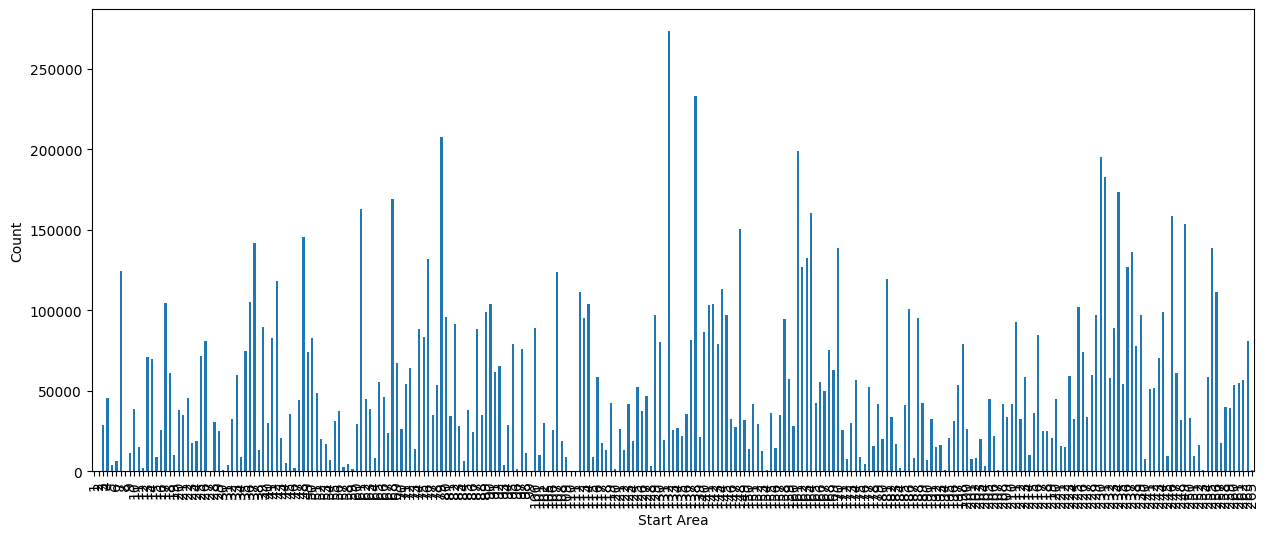

In [13]:
plt.figure(figsize=(15,6))
df['PULocationID'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Start Area")
plt.ylabel("Count")
plt.show()

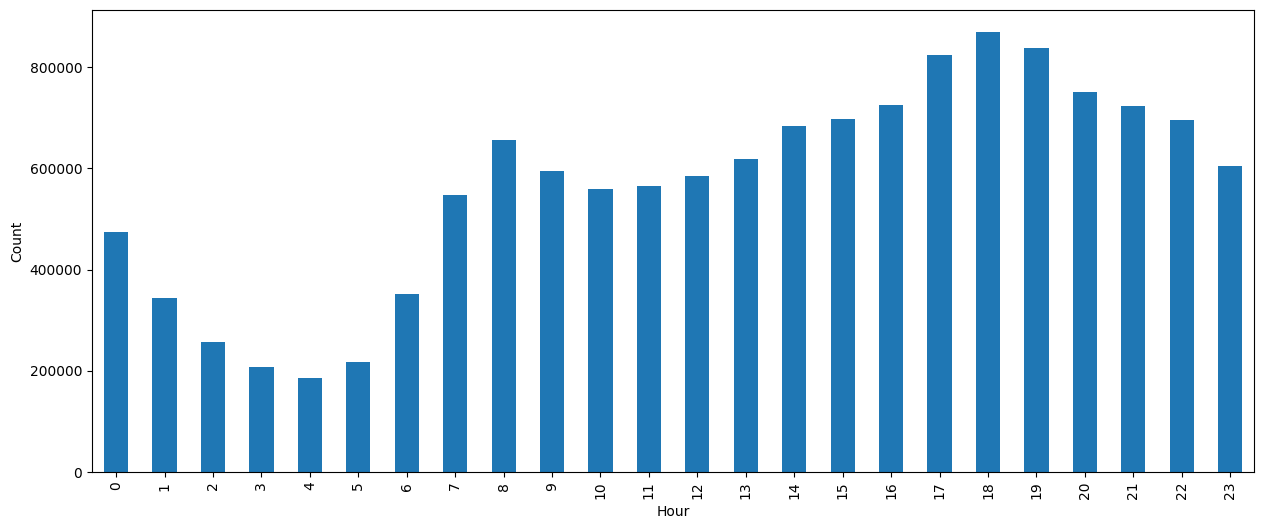

In [14]:
plt.figure(figsize=(15,6))
df['request_datetime'].dt.hour.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

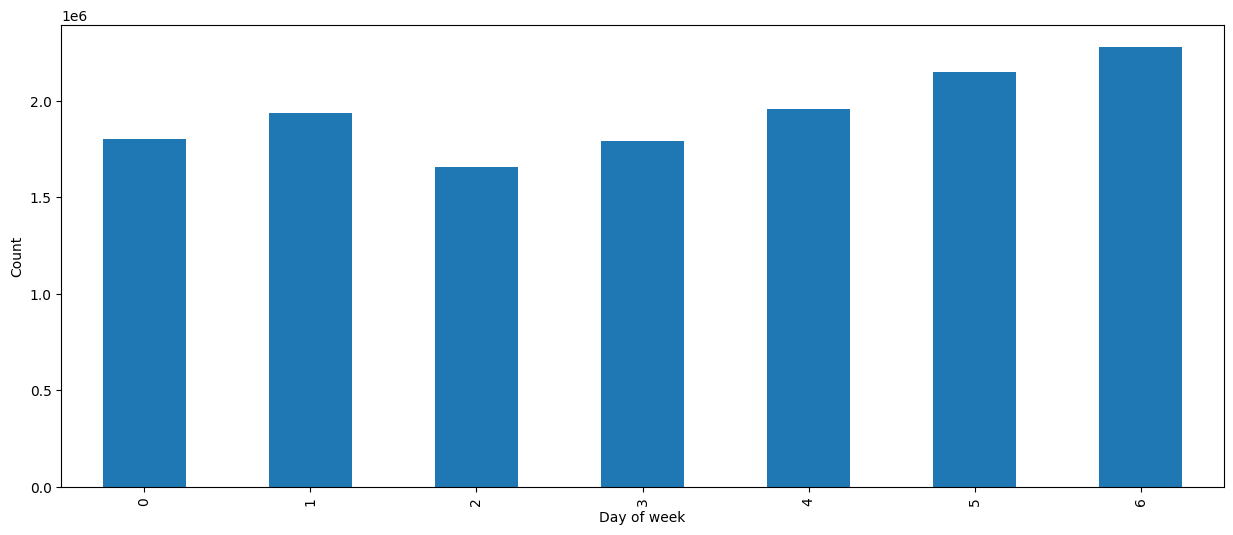

In [15]:
plt.figure(figsize=(15,6))
df['request_datetime'].dt.dayofweek.value_counts(sort=False).sort_index().plot(kind='bar')
#df['request_datetime'].dt.day_name().value_counts(sort=False).plot(kind='bar')
plt.xlabel("Day of week")
plt.ylabel("Count")
plt.show()

# Predicting Demand

In [16]:
X = demand[['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'PULocationID']]
y = demand['demand']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Unloading the dataframe to save memory
df = []
demand = []

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [21]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

/home/lenovo/Documents/Major Project/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))